In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 5}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)
#Set style
sns.set(style="whitegrid", palette="pastel", color_codes=True)

In [3]:
figSavePath = "/Users/kayaneh/Documents/deconvolution/figures/full_figure/maintext_revision1/fig3/"

sourceDataPath = "/Users/kayaneh/Documents/deconvolution/aip/source_data/fig2_sourceData.xlsx"

In [4]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

# necessary helper fns

In [5]:
def makeSigDict(sigPath):
    cellTypeSigs = pd.read_csv(sigPath, sep = ",", index_col = 0).T
    
    # based on file structure, transpose to use ENSG paths
    if "gini" in sigPath:
        cellTypeSigs = cellTypeSigs.T
    
    sigDict = {}
    for cellType in cellTypeSigs.columns:
        sigDict[cellType] = cellTypeSigs[cellType].dropna().index.tolist()
    
    
    return(sigDict)

In [6]:
"""
@param ctsDF = df of samples (genes x samps)
@returns zeroCenteredCtsDF = df of (genes x samps) with average subtracted
"""
def zeroCenterSingleBatch(cpmDF, relSRR):
    cpmDF = cpmDF[relSRR] # just subset to the SRR space you want to zero normalize with
    geneMean = cpmDF.mean(axis = 1).to_frame()
    geneMean = np.ndarray.flatten(geneMean.values)
    zeroCenteredCtsDF = cpmDF.sub(geneMean, axis = "index")
    return(zeroCenteredCtsDF)

In [7]:
"""
@param zeroCenterDF = dataframe gene zero centered samples
@param sigDict = dictionary with keys of str that are cell types and 
                values are lists of their unique marker genes
"""

def cis(zeroCenterDF, sigDict):
    
    cisRes = pd.DataFrame()
    for cell in sigDict:  
        
        geneList = sigDict[cell]

        intersection = np.intersect1d(geneList, zeroCenterDF.index.tolist())
        
        cellSig = zeroCenterDF.loc[intersection].sum(axis = 0).to_frame()
        cellSig.columns = [cell + "-CIS"]
        cisRes = pd.concat([cisRes, cellSig], axis = 1)
        
    return(cisRes)

In [8]:
# @param sampList = list of samples to consider a
# single batch in the column space of the cpm DF


def main(cpmDF, geneSigPath, 
         sampList):
    
    print("SAMP LIST = ", sampList)
    zeroCenteredCts = zeroCenterSingleBatch(cpmDF, sampList) 
    
    #### CIS TIME ####
    # make the DEG dictionary
    degDict = makeSigDict(geneSigPath) 

    
    # perform CIS
    cfCIS_Zero = cis(zeroCenteredCts, degDict)
    cfCIS_CPM = cis(cpmDF, degDict)
    
    
    cfCIS_Zero[~cfCIS_Zero.index.duplicated(keep='first')]
    cfCIS_CPM[~cfCIS_CPM.index.duplicated(keep='first')]
    
    return(cfCIS_Zero, cfCIS_CPM)

# read in the data

In [9]:
epoAprilCPMTMM = pd.read_csv("/Users/kayaneh/Documents/deconvolution/molecstetho/remapped_unstranded/epoONLYCPMTMM_09222021_INTRON3.csv",
                             sep = ",", index_col = [0, 1])
"""epoAprilCPMTMM = pd.read_csv("/Users/kayaneh/Documents/deconvolution/molecstetho/remapped_unstranded/epoONLYCPMOnly_12042021_INTRON3.csv",
                             sep = ",", index_col = [0, 1])"""




ckdTMM = epoAprilCPMTMM

In [10]:
ckdTMMLog = np.log(ckdTMM + 1)

In [21]:
meta = pd.read_csv("epometadata.csv", sep = ",", index_col = 0)

goodSamps = ckdTMM.columns.tolist()

meta = meta[meta["Run"].isin(goodSamps)]


allMeta = meta # just care about epo cohort
ckdTMM.fillna(0, inplace = True)

In [22]:
meta["status"] = ["CKD" if "EPO" in i else "CTRL" for i in meta["Patient"]]

In [23]:
np.unique(meta["status"], return_counts = True)

(array(['CKD', 'CTRL'], dtype=object), array([51,  9]))

In [24]:
# just get the samples in ckdTMM that belong to the epo cohort
ckdTMMLog = ckdTMMLog[allMeta["Run"]]

In [25]:
allMeta.set_index("Run", inplace = True)

In [26]:
libSize = epoAprilCPMTMM.iloc[:-6,:].sum(axis = 0).to_frame()
libSize.columns = ["libsize"]

In [27]:
libMeta = allMeta.join(libSize)

In [28]:
libMeta["cohort"] = ["epo" if "EPO" in i or "Control" in i else "fig1" for i in libMeta["Patient"]]

In [29]:
libMeta["status"] = ["CKD" if "EPO" in i else "CTRL" for i in libMeta["Sample Name"]]

In [30]:
epoLibs = libMeta[libMeta["cohort"] == "epo"]

In [31]:
epoLibs_ctrl = epoLibs[epoLibs["status"] == "CTRL"]["libsize"].values.tolist()

In [32]:
epoLibs_ckd = epoLibs[epoLibs["status"] == "CKD"]["libsize"].values.tolist()

<AxesSubplot:xlabel='libsize', ylabel='Count'>

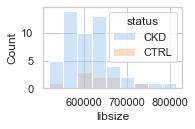

In [33]:
sns.histplot(data = epoLibs, x = "libsize", hue = "status")
# the distribution in library size between the CKD and CTRL samples in the EPO cohort are comparable 

No handles with labels found to put in legend.


Text(0.5, 1.0, 'epo and fig1 library size distribution')

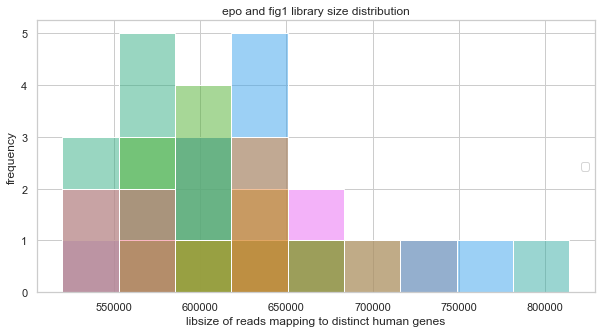

In [88]:
# distribution over all the samples
plt.figure(figsize = (10, 5))
sns.histplot(data = libMeta, x = 'libsize', hue = "Patient")

plt.legend(bbox_to_anchor=(1, 0.5))
plt.ylabel("frequency")
plt.xlabel("libsize of reads mapping to distinct human genes")
plt.title('epo and fig1 library size distribution')

In [89]:
ckdTMMLog.reset_index(inplace = True, drop = False)

In [90]:
ckdTMMLog.set_index("gene_num", inplace = True)
ckdTMMLog.drop("gene_name", inplace = True, axis = "columns")

In [91]:
# read in brain genes
basePath = "/Users/kayaneh/documents/deconvolution/signatures_git/"

kidneyGiniPath = "gini6_perCluster_kidney_12072020.csv"
kidneySigs = pd.read_csv(basePath + kidneyGiniPath, index_col = 0)
proximalTubuleSignature = kidneySigs["Proximal tubule-gini"].dropna().index.tolist()

In [92]:
# MAKE ROWSPACE OF ckdTMMLog to proximal tubule signature only
ckdTMMLog = ckdTMMLog.loc[np.intersect1d(ckdTMMLog.index, proximalTubuleSignature)]
ckdTMMLog.shape

(45, 60)

In [93]:
ctsMeta = ckdTMMLog.T.join(allMeta)

In [94]:
meltCtsMeta = pd.melt(ctsMeta, id_vars = ctsMeta.columns[-4:],
       value_vars = ctsMeta.columns[:-4])

In [95]:
# eliminate genes that have all zero counts in a given cohort (e.g. all zero in CKD or all-zero in healthy)

In [96]:
ctrlEpoENSG_dropout = []

for ensg in np.unique(meltCtsMeta["variable"]):
    thisGene = meltCtsMeta[meltCtsMeta["variable"] == ensg]
    ckdGene = thisGene[thisGene["status"] == "CKD"]["value"].values.tolist()
    ctrlGene = thisGene[thisGene["status"] == "CTRL"]["value"].values.tolist()
    
    if np.unique(ckdGene).tolist() == [0]:
        ctrlEpoENSG_dropout += [ensg]

    if np.unique(ctrlGene).tolist() == [0]:
        ctrlEpoENSG_dropout += [ensg]

        
# these are all the genes in either the CKD or CTRL batches that have no expression

# kill potential duplicate genes that are zero across both
ctrlEpoENSG_dropout = np.unique(ctrlEpoENSG_dropout).tolist() 
print(len(ctrlEpoENSG_dropout))

16


In [98]:
ctrlEpoENSG_dropout

['ENSG00000010932',
 'ENSG00000081479',
 'ENSG00000100253',
 'ENSG00000113492',
 'ENSG00000124564',
 'ENSG00000129151',
 'ENSG00000132437',
 'ENSG00000148942',
 'ENSG00000149452',
 'ENSG00000158296',
 'ENSG00000178828',
 'ENSG00000197901',
 'ENSG00000204653',
 'ENSG00000205279',
 'ENSG00000205358',
 'ENSG00000250799']

In [33]:
# the PT genes that are not part of the dropout list
goodGenes = np.setdiff1d(ckdTMMLog.index, ctrlEpoENSG_dropout)

# reindex the row space of ckdTMMLog to just the genes passing
ckdTMMLog = ckdTMMLog.loc[goodGenes]
ckdTMMLog.shape

(29, 60)

In [34]:
relSigs = {}

relSigs["PT"] = kidneySigs["Proximal tubule-gini"].dropna().index.tolist()


In [35]:
kidneySigs["Proximal tubule-gini"].dropna().index.tolist()

['ENSG00000153086',
 'ENSG00000183747',
 'ENSG00000066813',
 'ENSG00000132744',
 'ENSG00000116771',
 'ENSG00000113492',
 'ENSG00000136872',
 'ENSG00000166825',
 'ENSG00000204653',
 'ENSG00000129151',
 'ENSG00000145692',
 'ENSG00000164237',
 'ENSG00000205279',
 'ENSG00000107611',
 'ENSG00000132437',
 'ENSG00000015413',
 'ENSG00000147647',
 'ENSG00000162391',
 'ENSG00000010932',
 'ENSG00000171766',
 'ENSG00000149124',
 'ENSG00000211445',
 'ENSG00000243955',
 'ENSG00000244067',
 'ENSG00000116882',
 'ENSG00000138030',
 'ENSG00000081479',
 'ENSG00000100253',
 'ENSG00000125144',
 'ENSG00000205358',
 'ENSG00000144035',
 'ENSG00000086991',
 'ENSG00000174827',
 'ENSG00000250799',
 'ENSG00000135069',
 'ENSG00000139194',
 'ENSG00000178828',
 'ENSG00000081800',
 'ENSG00000158296',
 'ENSG00000165449',
 'ENSG00000124564',
 'ENSG00000197901',
 'ENSG00000149452',
 'ENSG00000131183',
 'ENSG00000148942',
 'ENSG00000137251',
 'ENSG00000171234']

In [36]:
allMeta["cohort"] = ["epo" if "EPO" in i or "Control" in i else "fig1" for i in allMeta["Patient"]]

In [37]:
allMeta["status"] = ["CKD" if 'EPO' in i else "CTRL" for i in allMeta["Patient"]]

In [38]:
ctrlMeta = ctsMeta[ctsMeta["status"] == "CTRL"]

In [39]:
# DO THE CIS
cisScore = cis(ckdTMMLog, relSigs)

In [40]:
cisMeta = cisScore.join(allMeta)

In [41]:
cisMeta.head()

,PT-CIS,Sample Name,Day,Patient,status,cohort
SRR8492548,22.989643,3408_004-EPO1,0,EPO1,CKD,epo
SRR8492550,22.841609,3417_004-EPO1,1,EPO1,CKD,epo
SRR8492552,20.398382,3446_004-EPO1,3,EPO1,CKD,epo
SRR8492555,22.099910,3533_004-EPO1,10,EPO1,CKD,epo
SRR8492551,18.405425,3492_004-EPO2,0,EPO2,CKD,epo


In [42]:
ctrlOnly = cisMeta[cisMeta['status'] == "CTRL"]

In [43]:
epoOnlyCIS = cisMeta[cisMeta["cohort"] == "epo"]

In [44]:
epoOnlyCIS.head()

,PT-CIS,Sample Name,Day,Patient,status,cohort
SRR8492548,22.989643,3408_004-EPO1,0,EPO1,CKD,epo
SRR8492550,22.841609,3417_004-EPO1,1,EPO1,CKD,epo
SRR8492552,20.398382,3446_004-EPO1,3,EPO1,CKD,epo
SRR8492555,22.099910,3533_004-EPO1,10,EPO1,CKD,epo
SRR8492551,18.405425,3492_004-EPO2,0,EPO2,CKD,epo


In [45]:
patient_colors = "#62b6cb #97c9d7 #c5dde4 #f1f1f1 #f0b8b8 #e67f83 #d43d51"
patient_colors = "#62b6cb #7fbecf #99c6d2 #b0cdd6 #c7d5d9 #dddddd #e1bfbf #e2a2a2 #e08386 #db636b #d43d51"
patient_colors = "#1b4965 #3b5484 #6f5998 #a7589b #d9568c #fd616d #ff7e45 #ffa600"
patient_colors = patient_colors.split(" ")
patient_colors = ["bee9e8","62b6cb","1b4965","cae9ff","5fa8d3"]
patient_colors = ["cae9ff","5fa8d3","573d1c","A80874", "62b6cb","1b4965","a690a4","afd2e9","FA9F42","124559","8a1c7c", "247ba0"]
patient_colors = ["#" + i for i in patient_colors]

sns.color_palette(patient_colors)

[(0.792156862745098, 0.9137254901960784, 1.0),
 (0.37254901960784315, 0.6588235294117647, 0.8274509803921568),
 (0.3411764705882353, 0.23921568627450981, 0.10980392156862745),
 (0.6588235294117647, 0.03137254901960784, 0.4549019607843137),
 (0.3843137254901961, 0.7137254901960784, 0.796078431372549),
 (0.10588235294117647, 0.28627450980392155, 0.396078431372549),
 (0.6509803921568628, 0.5647058823529412, 0.6431372549019608),
 (0.6862745098039216, 0.8235294117647058, 0.9137254901960784),
 (0.9803921568627451, 0.6235294117647059, 0.25882352941176473),
 (0.07058823529411765, 0.27058823529411763, 0.34901960784313724),
 (0.5411764705882353, 0.10980392156862745, 0.48627450980392156),
 (0.1411764705882353, 0.4823529411764706, 0.6274509803921569)]

Text(0, 0.5, 'Sum(Log transformed CPMTMM counts)')

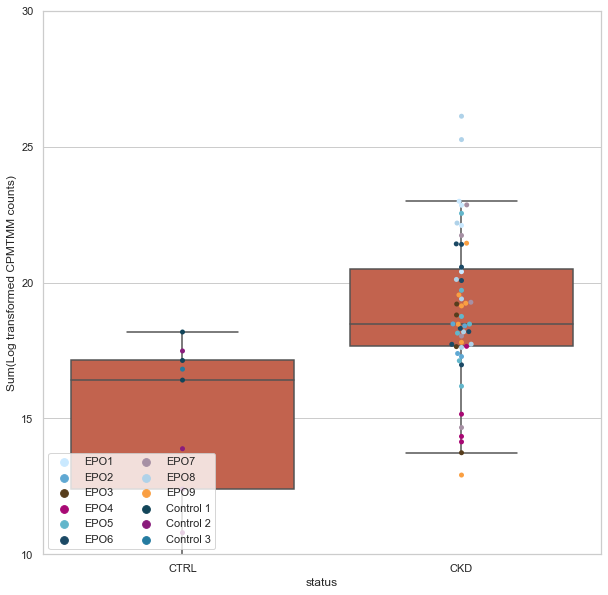

In [46]:
plt.figure(figsize = (10, 10))

sns.boxplot(data = epoOnlyCIS, 
            x = "status",
            y = "PT-CIS",
            color = "#D5573B",
            order = ["CTRL", "CKD"],
           fliersize = 0)

sns.swarmplot(data = epoOnlyCIS, 
            x = "status",
            y = "PT-CIS",
              palette = patient_colors,
              order = ["CTRL", "CKD"],
              hue = "Patient")

plt.ylim((10, 30))
plt.legend(loc = "lower left", ncol = 2)
#plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.yticks(np.arange(10, 31, 5))
plt.ylabel("Sum(Log transformed CPMTMM counts)")
#save_figure_pdf(plt, "ptSigScore_epoOnly_09232021.pdf")

In [46]:
"""with pd.ExcelWriter(sourceDataPath, mode = 'a') as writer:
            epoOnlyCIS.to_excel(writer, sheet_name = 'CKD', engine = 'xlsxwriter')"""

"with pd.ExcelWriter(sourceDataPath, mode = 'a') as writer:\n            epoOnlyCIS.to_excel(writer, sheet_name = 'CKD', engine = 'xlsxwriter')"

In [47]:
ckdEPO = epoOnlyCIS[epoOnlyCIS["status"] == "CKD"]["PT-CIS"].values.tolist()

In [48]:
ctrlEPO = epoOnlyCIS[epoOnlyCIS["status"] != "CKD"]["PT-CIS"].values.tolist()

In [49]:
mannwhitneyu(ckdEPO, ctrlEPO, alternative = "less")

MannwhitneyuResult(statistic=116.0, pvalue=0.009658300969876148)

# assess p-value calibration

In [50]:
np.random.seed(10)


pvals = []
difference = []
uList = []
for i in range(10000):
    newLabels = np.random.permutation(epoOnlyCIS["status"])

    epoOnlyCIS['shuffled'] = newLabels


    ckd = epoOnlyCIS[epoOnlyCIS['shuffled'] == "CKD"]['PT-CIS'].values.tolist()
    ctrl = epoOnlyCIS[epoOnlyCIS['shuffled'] != "CKD"]["PT-CIS"].values.tolist()

    
    #u_permute, p_permute = mannwhitneyu(ckd, ctrl, alternative = "two-sided")
    u_permute, p_permute = mannwhitneyu(ckd, ctrl, alternative = "less")


    uList += [u_permute]
    pvals += [p_permute]




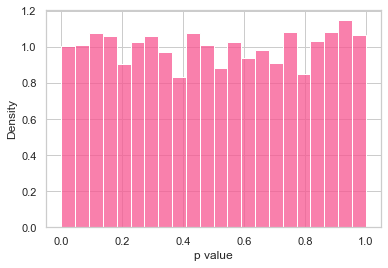

In [51]:
sns.histplot(pvals, color = "#f75590", stat = "density")
plt.xlabel("p value")
save_figure_pdf(plt, "ptSig_pValDistribPermutation_epoOnly_09222021.pdf")

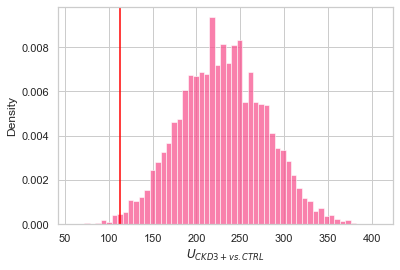

In [52]:
sns.histplot(uList, color = "#f75590", stat = "density")
plt.xlabel(r'$U_{CKD 3+ vs. CTRL}$')
plt.axvline(113, 0, 2, color = "red")
save_figure_pdf(plt, "ptSig_uValDistribPermutation_epoOnly_09222021.pdf")

In [53]:
greater = []
for i in uList:
    if i <= 113 : greater += [i]

In [54]:
len(greater) / 10000

0.0063